In [1]:
from datasets.dataset import Dataset
from datasets.domain import Domain
import os
from Util.qm import QueryManager
import argparse
import numpy as np
import time
import pandas as pd
import multiprocessing as mp
from Util import oracle, util2, benchmarks
from tqdm import tqdm
from hyperparameter_search import fem_grid_search
import matplotlib.pyplot as plt
from fem import get_iters
import itertools
import fem

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4
  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8
  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2
  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6
  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.
  7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4
  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8
  9.9 10. ]


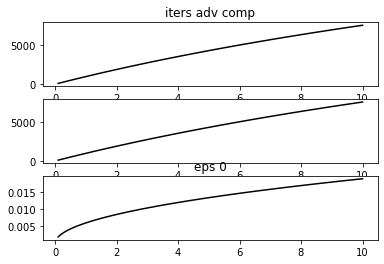

In [2]:
delta=0.000001
eps_list = np.arange(1, 101)/10
print(eps_list)
iters = []
iters_adv_comp = []
eps_0 = []
for e in eps_list:
    t, e0 = get_iters(e, delta, c=0.006)
    iters.append(t)
    eps_0.append(e0)
    t2 = util2.get_rounds(e, e0, delta)
    iters_adv_comp.append(t2)
    

plt.subplot(3,1,1)
plt.title('iters')
plt.plot(eps_list, iters, '-', c='k')
plt.title('iters adv comp')
plt.subplot(3,1,2)
plt.plot(eps_list, iters, '-', c='k')


plt.subplot(3,1,3)
plt.title('eps 0')
plt.plot(eps_list, eps_0, '-', c='k')
plt.show()


In [3]:
dataset = 'adult'
workload = 32
marginal = 3
 ######################################################
## Get dataset
######################################################
data, workloads = benchmarks.randomKway(dataset, workload, marginal)
N = data.df.shape[0]
delta = 1.0 / N ** 2

######################################################
## Get Queries
######################################################
stime = time.time()
query_manager = QueryManager(data.domain, workloads)
print("Number of queries = ", len(query_manager.queries))

real_ans = query_manager.get_answer(data)


Number of queries =  219189


In [4]:
def grid_search_min(f, X, Y, n_ave=3):
    progress = tqdm(total=len(eps_split_grid)*len(noise_mult_grid)*n_ave)

    min_value = 1
    best_x = None
    best_y = None
    all_values = {}
    for x, y in itertools.product(X, Y):
        values = []
        runtime = []
        for _ in range(n_ave):
            start_time = time.time()
            value = f(x, y)
            elapsed_time = time.time() - start_time
            runtime.append(elapsed_time)
            
            values.append(value)
            # Update
            
        if np.mean(values) < min_value:
            min_value = np.mean(values)
            best_x = x
            best_y = y
        all_values[(x,y)] = np.mean(values)
        
        progress.update()
        progress.set_postfix({'value': value, 'min-value':min_value})

    return min_value, all_values, best_x, best_y


    

In [5]:
epsilon_arr = [0.1, 0.5]
best_params = {}
eps_split_grid = np.array([5, 6, 7, 8, 9, 10])/1000
noise_mult_grid= [0.1, 0.12, 0.14, 0.16, 0.18]


# eps_split_grid = np.array([6, 9])/1000
# # noise_mult_grid=[0.03, 0.04, 0.05, 0.06, 0.07]
# noise_mult_grid=[ 0.1, 0.18]


results = {}
for epsilon in epsilon_arr:
    # optimization function
    def get_fem_error(eps0, noise):
        syndata = fem.generate(real_answers=real_ans,
                                            N=N,
                                            domain=data.domain,
                                            query_manager=query_manager,
                                            epsilon=epsilon,
                                            delta=delta,
                                            epsilon_split=eps0,
                                            noise_multiple=noise,
                                            samples=20,
                                            show_prgress=False)

        return np.abs(real_ans - query_manager.get_answer(syndata)).max()

    min_maxerror, all_errors, best_eps, best_noise = grid_search_min(get_fem_error, eps_split_grid, noise_mult_grid)
    
    best_params[epsilon] = (best_eps, best_noise)
    results[epsilon] = all_errors
    print(f'min maxerror = {min_maxerror} best_eps_split = {best_eps} best_noise_mult = {best_noise}')


  9%|▉         | 8/90 [2:54:48<25:13:19, 1107.31s/it, value=0.1, min-value=0.0976]  Process Process-132951:
Process Process-132954:
Process Process-132953:
Process Process-132956:
Process Process-132955:
Process Process-132952:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


In [ ]:
circle_size = 10000

fig, ax = plt.subplots(1, len(epsilon_arr), sharey=True)
print(ax)
for k, epsilon in enumerate(epsilon_arr):
#     plt.subplot(1, len(epsilon_arr), i+1)
    # print(best_params)
    grid = np.meshgrid(eps_split_grid, noise_mult_grid)
    ax[k].set_title(f'epsilon ={epsilon}')
    ax[k].plot(grid[0], grid[1], marker='.', color='k', linestyle='none')
    ax[k].set_xlabel('eps split')
    ax[k].set_ylabel('noise mult')
    print(f'epsilon = {epsilon}')
    for i, eps_0 in enumerate(eps_split_grid):
        for j, noise in enumerate(noise_mult_grid):
            error =  results[epsilon][(eps_0, noise)]
#             plt.scatter(eps_0, noise, circle_size * error, edgecolors='black', linewidths=1, facecolor='white')
            print(error)
            ax[k].annotate(f'{int(1000*error)}', (eps_0 , noise))
            
    b_eps, b_noise = best_params[epsilon]
    best_error = results[epsilon][(b_eps, b_noise)]
    ax[k].scatter(b_eps, b_noise, circle_size * best_error, edgecolors='black', linewidths=2, facecolor='yellow')
#     plt.ylim([0, np.max(noise_mult_grid) ])
#     plt.xlim([0, np.max(eps_split_grid) ])
    ax[k].grid(linestyle='--')
    ax[k].spines["right"].set_visible(False)
    ax[k].spines["left"].set_visible(False)
    
plt.show()

In [ ]:
print(results[0.1])
# print(best_params)


In [ ]:
print(results[0.5])